# World Financial Centers Clustering 
### by Neighborhood Nearby Venue Frequency

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium

from foursquare import venue_frequency, rank_venues_by_frequency, hash_venue_categories
from geocoder import enrich_neighborhoods_with_geocoder, map_neighborhoods, map_clusters

from yellowbrick.cluster import KElbowVisualizer

### Load mined datasets

In [8]:
world_coordinates = pd.read_csv('data/world_neighborhood_coords.csv', index_col=0)
world_coordinates

,Neighborhood,City,Latitude,Longitude
0,Yuqiao,Beijing,39.898820,116.670814
1,Shigezhuang,Beijing,39.931943,116.557680
2,Beitaipingzhuang,Beijing,39.973639,116.363844
3,Yongdingmenwai,Beijing,39.866794,116.392355
4,Jinding Avenue,Beijing,39.934977,116.389006
...,...,...,...,...
1262,Langstrasse,Zurich,47.377273,8.526415
1263,Enge,Zurich,47.361789,8.528708
1264,Lindenhof,Zurich,47.372916,8.540176
1265,Leimbach,Zurich,47.390254,8.581406


In [3]:
world_venues = pd.read_csv('data/world_neighborhood_venues.csv', index_col=0)
world_venues

,Neighborhood,City,Latitude,Longitude,Venue,Venue Category
0,Beitaipingzhuang,Beijing,39.973639,116.363844,Huayang Nianhua Guizhou Hometown Restaurant (贵...,Guizhou Restaurant
1,Beitaipingzhuang,Beijing,39.973639,116.363844,Pizza Hut (必胜客),Pizza Place
2,Beitaipingzhuang,Beijing,39.973639,116.363844,McDonald's (麦当劳),Fast Food Restaurant
3,Beitaipingzhuang,Beijing,39.973639,116.363844,嘉和一品 Jiahe Yipin Congee,Chinese Restaurant
4,Beitaipingzhuang,Beijing,39.973639,116.363844,Mudanyuan Metro Station (地铁牡丹园站),Metro Station
...,...,...,...,...,...,...
16327,Wipkingen,Zurich,47.393495,8.528602,Flying Pizza,Pizza Place
16328,Wipkingen,Zurich,47.393495,8.528602,ototo,Japanese Restaurant
16329,Wipkingen,Zurich,47.393495,8.528602,Bahnhof Zürich Wipkingen,Train Station
16330,Wipkingen,Zurich,47.393495,8.528602,Tre Frattelli,Italian Restaurant


In [9]:
world_venue_frequency = pd.read_csv('data/world_neighborhood_venues_frequency.csv', index_col=0)
world_venue_frequency

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Gate,Airport Lounge,Airport Service,American Restaurant,...,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,A Kung Ngam,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,Aberdeen,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,Adelaide,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025,...,0.0,0.0,0.025,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,Admiralty,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.019231,0.0,0.0,0.0,0.0
4,Agariyashiki,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,Zōshigaya,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.045455,0.000000,0.0,0.0,0.0,0.0
1058,one-north,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1059,Āntíng Zhèn,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1060,"Ōmori, Ōta",0.013889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [2]:
world_venues_ranked = pd.read_csv('data/world_neighborhood_venues_ranked.csv', index_col=0)
world_venues_ranked

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A Kung Ngam,History Museum,Zoo Exhibit,Fish & Chips Shop,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm
1,Aberdeen,Bus Station,Sushi Restaurant,Fast Food Restaurant,Bubble Tea Shop,Cha Chaan Teng,Supermarket,Athletics & Sports,Shopping Mall,Chinese Restaurant,Coffee Shop
2,Adelaide,Hotel,Italian Restaurant,Coffee Shop,Gastropub,Gym,Japanese Restaurant,Café,Restaurant,Hostel,Pizza Place
3,Admiralty,Café,Hotel,Cantonese Restaurant,Tea Room,Steakhouse,Hotel Bar,French Restaurant,Supermarket,Dessert Shop,Food Court
4,Agariyashiki,Event Space,Park,Garden,Convenience Store,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market
...,...,...,...,...,...,...,...,...,...,...,...
1057,Zōshigaya,Convenience Store,Café,Intersection,Platform,Tram Station,Restaurant,Candy Store,Grocery Store,Bakery,Bookstore
1058,one-north,Coffee Shop,Café,Noodle House,Sandwich Place,Asian Restaurant,Supermarket,Korean Restaurant,Beer Bar,Fried Chicken Joint,Thai Restaurant
1059,Āntíng Zhèn,Coffee Shop,Pizza Place,Italian Restaurant,Bus Station,Hotel,Fast Food Restaurant,Dessert Shop,Shopping Mall,Shanghai Restaurant,Movie Theater
1060,"Ōmori, Ōta",Convenience Store,Coffee Shop,Ramen Restaurant,Sake Bar,Japanese Restaurant,Discount Store,Grocery Store,Dumpling Restaurant,French Restaurant,Fast Food Restaurant


In [4]:
world_venue_frequency.columns

Index(['Neighborhood', 'ATM', 'Accessories Store', 'Adult Boutique',
       'Afghan Restaurant', 'African Restaurant', 'Airport Gate',
       'Airport Lounge', 'Airport Service', 'American Restaurant',
       ...
       'Wine Shop', 'Wings Joint', 'Women's Store', 'Xinjiang Restaurant',
       'Yakitori Restaurant', 'Yoga Studio', 'Yoshoku Restaurant',
       'Zhejiang Restaurant', 'Zoo', 'Zoo Exhibit'],
      dtype='object', length=522)

In [8]:
world_venue_frequency.sum(axis = 0, skipna = True)[1:].max()

51.27795764152135

In [3]:
top_three = world_venues_ranked.loc[:, 'Neighborhood':'3rd Most Common Venue']
top_three.dtypes

Neighborhood             object
1st Most Common Venue    object
2nd Most Common Venue    object
3rd Most Common Venue    object
dtype: object

In [4]:
h = hash_venue_categories(top_three)
h

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,Neighborhood
0,0,0,0,0,1,0,0,1,1,0,A Kung Ngam
1,1,0,1,1,0,0,0,0,0,0,Aberdeen
2,0,0,2,0,0,0,0,0,0,1,Adelaide
3,0,1,1,0,0,0,0,0,0,1,Admiralty
4,0,1,0,0,1,1,0,0,0,0,Agariyashiki
...,...,...,...,...,...,...,...,...,...,...,...
1057,0,0,2,0,0,0,1,0,0,0,Zōshigaya
1058,0,1,2,0,0,0,0,0,0,0,one-north
1059,0,0,2,0,0,1,0,0,0,0,Āntíng Zhèn
1060,1,0,1,0,0,0,1,0,0,0,"Ōmori, Ōta"


In [7]:
top_three.dtypes

Neighborhood             object
1st Most Common Venue    object
2nd Most Common Venue    object
3rd Most Common Venue    object
dtype: object

### Run k-means with default k

In [37]:
k = 25 # based on elbow method with hashing

In [5]:
world_venue_frequency_clustering = h.drop('Neighborhood', 1)
world_venue_frequency_clustering

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,0,0,0,0,1,0,0,1,1,0
1,1,0,1,1,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,0,1
3,0,1,1,0,0,0,0,0,0,1
4,0,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1057,0,0,2,0,0,0,1,0,0,0
1058,0,1,2,0,0,0,0,0,0,0
1059,0,0,2,0,0,1,0,0,0,0
1060,1,0,1,0,0,0,1,0,0,0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (112). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (112). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (113). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (113). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceW

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (130). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (130). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (131). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (131). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceW

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (148). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (148). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (149). Possibly due to duplicate points in X.
  return_n_iter=True)


1 : 2595.256120527307
2 : 2134.810288864372
3 : 1884.2175237856763
4 : 1719.0085178968377
5 : 1573.9288315169074
6 : 1459.6905265371074
7 : 1375.2260732664977
8 : 1262.1210881386683
9 : 1190.2666464445172
10 : 1142.2266260669142
11 : 1097.6950311531552
12 : 1057.2455365446951
13 : 1026.6526448768325
14 : 991.7892937871046
15 : 950.1002089402829
16 : 902.6143935036645
17 : 884.4443967203963
18 : 869.211809901094
19 : 845.1006285638713
20 : 810.7318632089127
21 : 755.145887737679
22 : 749.4500776278742
23 : 721.1607863180107
24 : 698.8261539501698
25 : 675.6824374509897
26 : 641.6675253721373
27 : 636.4541985498342
28 : 618.2408365468139
29 : 599.9733962183374
30 : 590.3647509852665
31 : 575.1003780835038
32 : 559.1239701315857
33 : 546.3316282686734
34 : 536.0240759158997
35 : 506.98620085189935
36 : 505.54400269483904
37 : 485.2877250090019
38 : 464.01266962365344
39 : 446.39538283185385
40 : 447.1557243668503
41 : 423.77102453900824
42 : 413.99460864229206
43 : 414.35912700208326
44 :

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (111) found smaller than n_clusters (149). Possibly due to duplicate points in X.
  return_n_iter=True)


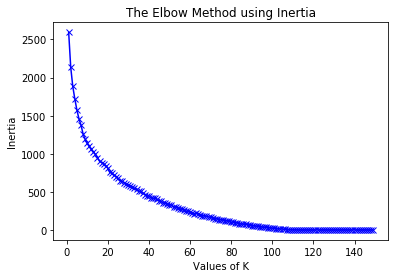

In [7]:
# find best k
def plot_best_k(X):
    distortions = [] 
    inertias = [] 
    mapping1 = {} 
    mapping2 = {} 
    K = range(1,150) 

    for k in K: 
        kmeanModel = KMeans(n_clusters=k).fit(X) 
        kmeanModel.fit(X)     
        inertias.append(kmeanModel.inertia_) 
        mapping2[k] = kmeanModel.inertia_ 
    
    for key,val in mapping2.items(): 
        print(str(key)+' : '+str(val)) 
    
    plt.plot(K, inertias, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('Inertia') 
    plt.title('The Elbow Method using Inertia') 
    plt.show() 

plot_best_k(world_venue_frequency_clustering)

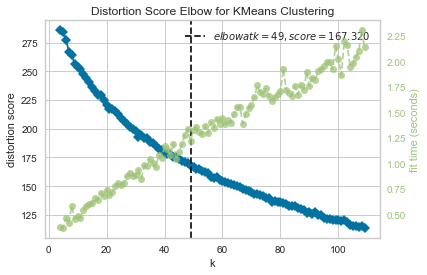

In [10]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,110))

visualizer.fit(world_venue_frequency.drop('Neighborhood', 1))
visualizer.show()

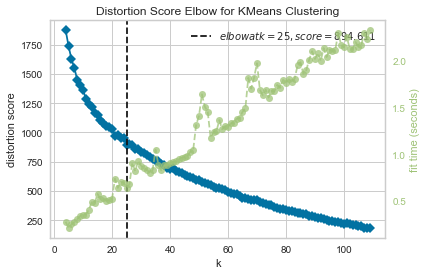

In [6]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,110))

visualizer.fit(world_venue_frequency_clustering)
visualizer.show()

In [7]:
k=25

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(world_venue_frequency_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([12,  3,  1, 20,  0,  7,  2,  1, 12, 17], dtype=int32)

In [10]:
# add clustering labels
world_venues_ranked.insert(0, "Cluster Labels", kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
clustered_neighborhoods = world_venues_ranked.join(world_coordinates.set_index('Neighborhood'), on='Neighborhood', how="inner")
clustered_neighborhoods.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
0,12,A Kung Ngam,History Museum,Zoo Exhibit,Fish & Chips Shop,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Hong Kong,22.280861,114.233845
1,3,Aberdeen,Bus Station,Sushi Restaurant,Fast Food Restaurant,Bubble Tea Shop,Cha Chaan Teng,Supermarket,Athletics & Sports,Shopping Mall,Chinese Restaurant,Coffee Shop,Hong Kong,22.248769,114.155954
2,1,Adelaide,Hotel,Italian Restaurant,Coffee Shop,Gastropub,Gym,Japanese Restaurant,Café,Restaurant,Hostel,Pizza Place,Toronto,43.650809,-79.377917
3,20,Admiralty,Café,Hotel,Cantonese Restaurant,Tea Room,Steakhouse,Hotel Bar,French Restaurant,Supermarket,Dessert Shop,Food Court,Hong Kong,22.278921,114.164498
3,20,Admiralty,Café,Hotel,Cantonese Restaurant,Tea Room,Steakhouse,Hotel Bar,French Restaurant,Supermarket,Dessert Shop,Food Court,Singapore,1.440637,103.800959


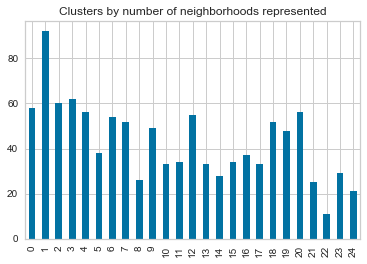

In [73]:
clustered_neighborhoods['Cluster Labels'].value_counts().sort_index().plot(kind='bar')
plt.title('Clusters by number of neighborhoods represented')
plt.show()

In [23]:
clustered_for_mapping = clustered_neighborhoods[['Cluster Labels', 'Neighborhood', 'City', 'Latitude', 'Longitude']]
clustered_for_mapping

,Cluster Labels,Neighborhood,City,Latitude,Longitude
0,12,A Kung Ngam,Hong Kong,22.280861,114.233845
1,3,Aberdeen,Hong Kong,22.248769,114.155954
2,1,Adelaide,Toronto,43.650809,-79.377917
3,20,Admiralty,Hong Kong,22.278921,114.164498
3,20,Admiralty,Singapore,1.440637,103.800959
...,...,...,...,...,...
1057,1,Zōshigaya,Tokyo,35.720165,139.714744
1058,1,one-north,Singapore,1.299607,103.787241
1059,1,Āntíng Zhèn,Shanghai,31.290364,121.157515
1060,4,"Ōmori, Ōta",Tokyo,35.588473,139.727933


In [24]:
clustered_for_mapping[clustered_for_mapping.index.duplicated()]

,Cluster Labels,Neighborhood,City,Latitude,Longitude
3,20,Admiralty,Singapore,1.440637,103.800959
48,11,Bay Terrace,New York City,40.553988,-74.139166
52,7,Bedford Park,Toronto,43.737388,-79.410925
128,9,Chelsea,New York City,40.594726,-74.189560
135,4,Chinatown,Singapore,1.283737,103.843798
135,4,Chinatown,Toronto,43.652924,-79.398032
176,9,Coney Island,Singapore,1.409418,103.921470
396,18,Islington,Toronto,43.645338,-79.524870
588,5,Murray Hill,New York City,40.764126,-73.812763
713,4,Riverdale,Toronto,43.665470,-79.352594


In [25]:
# drop duplicated index - move this to before modeling step
clustered_for_mapping = clustered_for_mapping[~clustered_for_mapping.index.duplicated()]
clustered_for_mapping.reset_index(drop=True, inplace=True)
clustered_for_mapping

,Cluster Labels,Neighborhood,City,Latitude,Longitude
0,12,A Kung Ngam,Hong Kong,22.280861,114.233845
1,3,Aberdeen,Hong Kong,22.248769,114.155954
2,1,Adelaide,Toronto,43.650809,-79.377917
3,20,Admiralty,Hong Kong,22.278921,114.164498
4,0,Agariyashiki,Tokyo,35.726435,139.705216
...,...,...,...,...,...
1057,1,Zōshigaya,Tokyo,35.720165,139.714744
1058,1,one-north,Singapore,1.299607,103.787241
1059,1,Āntíng Zhèn,Shanghai,31.290364,121.157515
1060,4,"Ōmori, Ōta",Tokyo,35.588473,139.727933


In [26]:
clustered_for_mapping['Cluster Labels'] = clustered_for_mapping['Cluster Labels'].astype('category')
clustered_for_mapping['City'] = clustered_for_mapping['City'].astype('category')

clustered_for_mapping

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Cluster Labels,Neighborhood,City,Latitude,Longitude
0,12,A Kung Ngam,Hong Kong,22.280861,114.233845
1,3,Aberdeen,Hong Kong,22.248769,114.155954
2,1,Adelaide,Toronto,43.650809,-79.377917
3,20,Admiralty,Hong Kong,22.278921,114.164498
4,0,Agariyashiki,Tokyo,35.726435,139.705216
...,...,...,...,...,...
1057,1,Zōshigaya,Tokyo,35.720165,139.714744
1058,1,one-north,Singapore,1.299607,103.787241
1059,1,Āntíng Zhèn,Shanghai,31.290364,121.157515
1060,4,"Ōmori, Ōta",Tokyo,35.588473,139.727933


In [28]:
p = clustered_for_mapping[['City', 'Cluster Labels']].pivot_table(values='City', index='Cluster Labels', aggfunc=set)
p

,City
Cluster Labels,
0,"{Tokyo, London, Toronto, New York City, Frankf..."
1,"{Tokyo, London, Toronto, New York City, Frankf..."
2,"{Tokyo, London, Toronto, New York City, Frankf..."
3,"{Tokyo, London, Toronto, New York City, Frankf..."
4,"{Tokyo, London, Toronto, New York City, Shangh..."
5,"{Tokyo, Toronto, New York City, Frankfurt, Sha..."
6,"{Tokyo, London, Toronto, New York City, Frankf..."
7,"{Tokyo, Toronto, New York City, Frankfurt, Sha..."
8,"{Tokyo, London, Toronto, New York City, Shangh..."


In [29]:
p2 = clustered_for_mapping[['City', 'Cluster Labels']].pivot_table(values='Cluster Labels', index='City', aggfunc=set)
p2

,Cluster Labels
City,
Beijing,"{0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 1..."
Frankfurt,"{0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 15, 1..."
Hong Kong,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
London,"{0, 1, 2, 3, 4, 6, 8, 9, 10, 12, 13, 15, 16, 1..."
New York City,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
Shanghai,"{0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 17..."
Singapore,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
Tokyo,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
Toronto,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
# See Tableau dashboard for better vizualization of cluster distribution

### Save assigned clusters

In [60]:
clustered_neighborhoods.to_csv('data/world_neighborhood_venues_clustered.csv')

## Visualize geospatial clusters

In [31]:
t = map_clusters(clustered_for_mapping[clustered_for_mapping['City'] == 'Toronto'], k, 'Toronto, Ontario')
t

In [38]:
tk = map_clusters(clustered_for_mapping[clustered_for_mapping['City'] == 'Tokyo'], k, 'Tokyo, Japan')
tk

In [39]:
z = map_clusters(clustered_for_mapping[clustered_for_mapping['City'] == 'Zurich'], k, 'Zurich, Switzerland')
z

In [40]:
b = map_clusters(clustered_for_mapping[clustered_for_mapping['City'] == 'Beijing'], k, 'Beijing, China')
b

In [41]:
ny = map_clusters(clustered_for_mapping[clustered_for_mapping['City'] == 'New York City'], k, 'New York City, NY')
ny

In [42]:
shang = map_clusters(clustered_for_mapping[clustered_for_mapping['City'] == 'Shanghai'], k, 'Shanghai, China')
shang

In [45]:
sing = map_clusters(clustered_for_mapping[clustered_for_mapping['City'] == 'Singapore'], k, 'Singapore, China')
sing

In [46]:
f = map_clusters(clustered_for_mapping[clustered_for_mapping['City'] == 'Frankfurt'], k, 'Frankfurt, Germany')
f

In [47]:
l = map_clusters(clustered_for_mapping[clustered_for_mapping['City'] == 'London'], k, 'London, England')
l

In [48]:
hk = map_clusters(clustered_for_mapping[clustered_for_mapping['City'] == 'Hong Kong'], k, 'Hong Kong, China')
hk

## Analyze clusters by venue rankings

## Cluster 0 - Fast Food, Zoo Exhibits, Ethiopian Food

In [52]:
cluster_0 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 0]
cluster_0.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
4,0,Agariyashiki,Event Space,Park,Garden,Convenience Store,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,Tokyo,35.726435,139.705216
92,0,Bronxdale,Bakery,Metro Station,Zoo Exhibit,Fish Market,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,New York City,40.852723,-73.861726
110,0,Canarsie,Asian Restaurant,Bus Line,Deli / Bodega,Chinese Restaurant,Festival,Fish Market,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,New York City,40.635564,-73.902093
120,0,Central Harlem,Cosmetics Shop,Music Venue,Vegetarian / Vegan Restaurant,Bus Stop,Fried Chicken Joint,Café,Deli / Bodega,French Restaurant,Breakfast Spot,Southern / Soul Food Restaurant,New York City,40.815976,-73.943211
126,0,Charleston,Arts & Crafts Store,Irish Pub,Movie Theater,Big Box Store,Department Store,Cosmetics Shop,Bus Line,Italian Restaurant,Falafel Restaurant,Farm,New York City,40.530531,-74.232158
141,0,Chung Hom Kok,Grocery Store,Zoo Exhibit,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Hong Kong,22.218262,114.204761
178,0,Country Club,Vegetarian / Vegan Restaurant,Sandwich Place,Zoo Exhibit,Farmers Market,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farm,Fish & Chips Shop,New York City,40.844246,-73.824099
206,0,Dorset Park,Furniture / Home Store,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Toronto,43.752847,-79.282067
210,0,Downsview North,Metro Station,Bus Station,Park,Furniture / Home Store,Gym / Fitness Center,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Zoo Exhibit,Toronto,43.749299,-79.462248
215,0,Dàchǎng Zhèn,Chinese Restaurant,Metro Station,Zoo Exhibit,Fish Market,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Shanghai,31.294144,121.412396


In [57]:
cluster_0['1st Most Common Venue'].value_counts()[0:5]

Fast Food Restaurant    8
Metro Station           4
Grocery Store           3
Park                    3
Noodle House            3
Name: 1st Most Common Venue, dtype: int64

In [58]:
cluster_0['2nd Most Common Venue'].value_counts()[0:5]

Zoo Exhibit          25
Metro Station         4
Noodle House          2
Bus Line              2
Convenience Store     2
Name: 2nd Most Common Venue, dtype: int64

In [59]:
cluster_0['3rd Most Common Venue'].value_counts()[0:5]

Ethiopian Restaurant    16
Zoo Exhibit              9
Event Space              7
Fishing Spot             4
Chinese Restaurant       2
Name: 3rd Most Common Venue, dtype: int64

In [61]:
cluster_0.shape

(58, 15)

## Cluster 1 - Cafes, Coffee, Italian Food

In [74]:
cluster_1 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 1]
cluster_1.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
2,1,Adelaide,Hotel,Italian Restaurant,Coffee Shop,Gastropub,Gym,Japanese Restaurant,Café,Restaurant,Hostel,Pizza Place,Toronto,43.650809,-79.377917
7,1,Akasaka,Chinese Restaurant,Coffee Shop,Italian Restaurant,Café,French Restaurant,Japanese Restaurant,Asian Restaurant,Spanish Restaurant,Soba Restaurant,BBQ Joint,Tokyo,35.671679,139.735622
36,1,Babaoshan,Curling Ice,Hotpot Restaurant,Chinese Restaurant,Electronics Store,Fast Food Restaurant,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farm,Beijing,39.906235,116.229630
45,1,Bathurst Quay,Coffee Shop,Tunnel,Café,Japanese Restaurant,Sushi Restaurant,Sculpture Garden,Grocery Store,Park,Festival,Fast Food Restaurant,Toronto,43.635791,-79.398329
62,1,Bendemeer,Café,Coffee Shop,Zoo Exhibit,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farm,Singapore,1.313821,103.862928
72,1,Boat Quay,Salad Place,Coffee Shop,Italian Restaurant,Plaza,Cocktail Bar,Seafood Restaurant,Lounge,Bar,History Museum,Comfort Food Restaurant,Singapore,1.285939,103.852150
74,1,Boerum Hill,Furniture / Home Store,Coffee Shop,Indian Restaurant,Cocktail Bar,Men's Store,Middle Eastern Restaurant,Bar,Bakery,Sandwich Place,Spa,New York City,40.685683,-73.983748
79,1,Bornheim,Italian Restaurant,Pool,Gymnastics Gym,Pool Hall,Fountain,Financial or Legal Service,Event Space,Exhibit,Fabric Shop,Factory,Frankfurt,50.133056,8.714932
90,1,Brockton,Coffee Shop,Grocery Store,Café,Zoo Exhibit,Fast Food Restaurant,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farmers Market,Toronto,43.650917,-79.440022
99,1,Bukit Merah,Bookstore,Cupcake Shop,Café,Yoga Studio,Restaurant,Boutique,Ice Cream Shop,Financial or Legal Service,Filipino Restaurant,Field,Singapore,1.280628,103.830591


In [75]:
cluster_1['1st Most Common Venue'].value_counts()[0:5]

Café                  17
Coffee Shop           16
Italian Restaurant    12
Chinese Restaurant     3
Sushi Restaurant       3
Name: 1st Most Common Venue, dtype: int64

In [76]:
cluster_1['2nd Most Common Venue'].value_counts()[0:5]

Café                  17
Coffee Shop           15
Italian Restaurant    14
Bus Stop               3
Grocery Store          2
Name: 2nd Most Common Venue, dtype: int64

In [77]:
cluster_1['3rd Most Common Venue'].value_counts()[0:5]

Coffee Shop           17
Italian Restaurant    12
Café                  10
Sushi Restaurant       3
Zoo Exhibit            3
Name: 3rd Most Common Venue, dtype: int64

In [78]:
cluster_1.shape

(92, 15)

## Cluster 2 - Chinese Food, Fast Food, Convenience Stores

In [79]:
cluster_2 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 2]
cluster_2.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
6,2,Agincourt North,Japanese Restaurant,Fried Chicken Joint,Chinese Restaurant,Clothing Store,Pizza Place,Wings Joint,Dim Sum Restaurant,Ice Cream Shop,Fast Food Restaurant,Convenience Store,Toronto,43.808038,-79.266439
12,2,Aldrich Bay,Chinese Restaurant,Cantonese Restaurant,French Restaurant,Hong Kong Restaurant,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Hong Kong,22.282446,114.221506
51,2,Bayview Village,Breakfast Spot,Outdoor Supply Store,Sporting Goods Shop,Persian Restaurant,Fish Market,Pet Store,Sandwich Place,Gas Station,Pizza Place,Metro Station,Toronto,43.769197,-79.376662
56,2,Beixinqiao,Chinese Restaurant,Bar,Japanese Restaurant,Zhejiang Restaurant,French Restaurant,Sandwich Place,Brewery,Café,Fast Food Restaurant,Financial or Legal Service,Beijing,39.939384,116.410870
65,2,Bexley,Pub,Fast Food Restaurant,Breakfast Spot,Greek Restaurant,Chinese Restaurant,Indian Restaurant,Financial or Legal Service,Filipino Restaurant,Field,Festival,London,51.441679,0.150488
76,2,Boon Keng,Noodle House,Chinese Restaurant,Fast Food Restaurant,Soup Place,Shopping Mall,Food Court,Dessert Shop,Sandwich Place,Bakery,Coffee Shop,Singapore,1.319569,103.861749
105,2,Běixīnjīng,Fast Food Restaurant,Market,Metro Station,Dumpling Restaurant,Convenience Store,Coffee Shop,Bakery,Shopping Plaza,Hotel,Factory,Shanghai,31.218828,121.368126
108,2,Cambria Heights,Caribbean Restaurant,Health Food Store,Cosmetics Shop,Nightclub,Bus Station,Fried Chicken Joint,Fish & Chips Shop,Event Space,Exhibit,Fabric Shop,New York City,40.692775,-73.735269
139,2,Chong Boon,Bus Line,Chinese Restaurant,Pharmacy,Food Court,Fast Food Restaurant,Bus Station,Halal Restaurant,Hainan Restaurant,Convenience Store,Zoo Exhibit,Singapore,1.368207,103.856360
169,2,College Point,Bus Station,Convenience Store,Pharmacy,Bank,Caribbean Restaurant,Spanish Restaurant,Video Store,Latin American Restaurant,Sandwich Place,Asian Restaurant,New York City,40.784903,-73.843045


In [80]:
cluster_2['1st Most Common Venue'].value_counts()[0:5]

Chinese Restaurant      11
Fast Food Restaurant     6
Japanese Restaurant      5
Convenience Store        3
Light Rail Station       2
Name: 1st Most Common Venue, dtype: int64

In [81]:
cluster_2['2nd Most Common Venue'].value_counts()[0:5]

Fast Food Restaurant    9
Chinese Restaurant      7
Convenience Store       5
Zoo Exhibit             5
Antique Shop            2
Name: 2nd Most Common Venue, dtype: int64

In [82]:
cluster_2['3rd Most Common Venue'].value_counts()[0:5]

Chinese Restaurant      7
Fast Food Restaurant    7
Pharmacy                5
Metro Station           3
Jewelry Store           2
Name: 3rd Most Common Venue, dtype: int64

In [83]:
cluster_2.shape

(60, 15)

## Cluster 3 - Supermarket, Zoo Exhibit, Fish Market

In [84]:
cluster_3 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 3]
cluster_3.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
1,3,Aberdeen,Bus Station,Sushi Restaurant,Fast Food Restaurant,Bubble Tea Shop,Cha Chaan Teng,Supermarket,Athletics & Sports,Shopping Mall,Chinese Restaurant,Coffee Shop,Hong Kong,22.248769,114.155954
10,3,Albisrieden,Swiss Restaurant,Supermarket,Café,Tram Station,Restaurant,Bus Station,Grocery Store,Bakery,Filipino Restaurant,Field,Zurich,47.374857,8.484657
18,3,Altstetten,Supermarket,Swiss Restaurant,Italian Restaurant,Discount Store,Mediterranean Restaurant,Tram Station,Mexican Restaurant,Fast Food Restaurant,Plaza,Hotel,Zurich,47.387403,8.486061
22,3,Ang Mo Kio,Dessert Shop,Japanese Restaurant,Supermarket,Fast Food Restaurant,Bakery,Pharmacy,Coffee Shop,Shopping Mall,Gym / Fitness Center,Snack Place,Singapore,1.370073,103.849516
81,3,Braemar Hill,Scenic Lookout,Fish Market,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Hong Kong,22.286418,114.206442
85,3,Briarwood,Playground,Fast Food Restaurant,Plaza,Zoo Exhibit,Fish & Chips Shop,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,New York City,40.710935,-73.811748
114,3,Castle Hill,Pharmacy,Diner,Zoo Exhibit,Fast Food Restaurant,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farmers Market,New York City,40.819014,-73.848027
125,3,Chaoyangmen,Asian Restaurant,Hotpot Restaurant,Bus Station,Fast Food Restaurant,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Zoo Exhibit,Beijing,39.924997,116.428879
131,3,Chengnan,Lake,Zoo Exhibit,Fast Food Restaurant,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farmers Market,Fishing Spot,Beijing,40.299030,116.637321
136,3,Choa Chu Kang,Dive Spot,Playground,Park,Zoo Exhibit,Fast Food Restaurant,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farmers Market,Singapore,1.389260,103.743728


In [85]:
cluster_3['1st Most Common Venue'].value_counts()[0:5]

Supermarket           6
Coffee Shop           5
Asian Restaurant      4
Italian Restaurant    4
Playground            4
Name: 1st Most Common Venue, dtype: int64

In [86]:
cluster_3['2nd Most Common Venue'].value_counts()[0:5]

Zoo Exhibit             13
Japanese Restaurant      4
Fast Food Restaurant     4
Fish Market              3
Coffee Shop              3
Name: 2nd Most Common Venue, dtype: int64

In [87]:
cluster_3['3rd Most Common Venue'].value_counts()[0:5]

Fish Market             12
Zoo Exhibit              5
Fast Food Restaurant     4
Bus Station              4
Plaza                    3
Name: 3rd Most Common Venue, dtype: int64

In [88]:
cluster_3.shape

(62, 15)

## Cluster 4 - Chinese Restaurant, Coffee Shop, Convenience Store

In [89]:
cluster_4 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 4]
cluster_4.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
50,4,Bayside,Shipping Store,Indian Restaurant,Mediterranean Restaurant,Health & Beauty Service,Pharmacy,Bakery,Greek Restaurant,Pizza Place,Vietnamese Restaurant,Spa,New York City,40.766041,-73.774274
58,4,Bellaire,Convenience Store,Grocery Store,Chinese Restaurant,Indian Restaurant,Zoo Exhibit,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,New York City,40.733014,-73.738892
135,4,Chinatown,Chinese Restaurant,Hotpot Restaurant,Noodle House,Hostel,Dumpling Restaurant,Café,Bubble Tea Shop,Spa,Vietnamese Restaurant,Food Court,New York City,40.715618,-73.994279
135,4,Chinatown,Chinese Restaurant,Hotpot Restaurant,Noodle House,Hostel,Dumpling Restaurant,Café,Bubble Tea Shop,Spa,Vietnamese Restaurant,Food Court,Singapore,1.283737,103.843798
135,4,Chinatown,Chinese Restaurant,Hotpot Restaurant,Noodle House,Hostel,Dumpling Restaurant,Café,Bubble Tea Shop,Spa,Vietnamese Restaurant,Food Court,Toronto,43.652924,-79.398032
151,4,City One Shatin,Chinese Restaurant,Coffee Shop,Noodle House,Bubble Tea Shop,Convenience Store,Dumpling Restaurant,Pharmacy,Hong Kong Restaurant,Shabu-Shabu Restaurant,Asian Restaurant,Hong Kong,22.386618,114.203512
171,4,Commonwealth,Noodle House,Chinese Restaurant,Supermarket,Candy Store,Bus Station,Market,Fried Chicken Joint,Train Station,Soccer Field,Ice Cream Shop,Singapore,1.302443,103.798309
188,4,Dashilan,Shopping Mall,Beijing Restaurant,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Tea Room,Clothing Store,Shoe Store,Pharmacy,Peking Duck Restaurant,Beijing,39.894498,116.390172
219,4,East Birchmount Park,Beer Store,Gym,Intersection,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Zoo Exhibit,Toronto,43.714167,-79.271109
220,4,East Flatbush,Supermarket,Print Shop,Chinese Restaurant,Pharmacy,Fast Food Restaurant,Moving Target,Food & Drink Shop,Hardware Store,Department Store,Food Stand,New York City,40.641718,-73.936103


In [90]:
cluster_4['1st Most Common Venue'].value_counts()[0:5]

Chinese Restaurant        14
Coffee Shop                7
Convenience Store          4
Italian Restaurant         3
Furniture / Home Store     2
Name: 1st Most Common Venue, dtype: int64

In [91]:
cluster_4['2nd Most Common Venue'].value_counts()[0:5]

Coffee Shop           6
Chinese Restaurant    6
Convenience Store     5
Bakery                4
Hotpot Restaurant     3
Name: 2nd Most Common Venue, dtype: int64

In [92]:
cluster_4['3rd Most Common Venue'].value_counts()[0:5]

Chinese Restaurant    10
Grocery Store          5
Noodle House           4
Coffee Shop            3
Supermarket            3
Name: 3rd Most Common Venue, dtype: int64

In [93]:
cluster_4.shape

(56, 15)

## Cluster 5 - Train Station, Hotel, Event Service

In [94]:
cluster_5 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 5]
cluster_5.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
17,5,Altstadt,Café,Art Museum,German Restaurant,Plaza,Wine Bar,Gift Shop,Italian Restaurant,Burger Joint,Ice Cream Shop,Pastry Shop,Frankfurt,50.111045,8.682936
31,5,Asagaya,Café,BBQ Joint,Takoyaki Place,Ramen Restaurant,Italian Restaurant,Sake Bar,Event Space,Grocery Store,Chinese Restaurant,Thai Restaurant,Tokyo,35.703164,139.636247
83,5,Breezy Point,Monument / Landmark,Event Service,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,New York City,40.557401,-73.925512
96,5,Bugis,Japanese Restaurant,Dessert Shop,Hotel,Shopping Mall,Sushi Restaurant,Bakery,Café,Building,Thai Restaurant,Coffee Shop,Singapore,1.299953,103.855278
146,5,Chēdūn Zhèn,Train Station,Fish Market,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Shanghai,31.007295,121.316357
257,5,Flatlands,Liquor Store,Fast Food Restaurant,Caribbean Restaurant,Seafood Restaurant,Pharmacy,Dessert Shop,Paper / Office Supplies Store,Asian Restaurant,Discount Store,Filipino Restaurant,New York City,40.630446,-73.929113
383,5,Héqìng Zhèn,Hotel,Zoo Exhibit,Fish & Chips Shop,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Shanghai,31.239458,121.719039
387,5,Hǎiwān Zhèn,Hotel,Zoo Exhibit,Fish & Chips Shop,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Shanghai,30.862943,121.563245
404,5,Jiaodaokou,Burger Joint,Theater,Chinese Restaurant,Music Venue,Pub,Festival,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Beijing,39.934272,116.402493
412,5,Jiǔlǐtíng,Hotel,Zoo Exhibit,Fish & Chips Shop,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Shanghai,31.143458,121.306585


In [95]:
cluster_5['1st Most Common Venue'].value_counts()[0:5]

Train Station           8
Hotel                   6
Korean Restaurant       3
Caribbean Restaurant    3
Burger Joint            2
Name: 1st Most Common Venue, dtype: int64

In [96]:
cluster_5['2nd Most Common Venue'].value_counts()[0:5]

Zoo Exhibit      7
Fish Market      6
Coffee Shop      2
Event Service    2
Dessert Shop     2
Name: 2nd Most Common Venue, dtype: int64

In [97]:
cluster_5['3rd Most Common Venue'].value_counts()[0:5]

Event Service        8
Fish & Chips Shop    6
Hotel                3
Korean Restaurant    3
Food                 2
Name: 3rd Most Common Venue, dtype: int64

In [98]:
cluster_5.shape

(38, 15)

## Cluster 6 - Pizza Place, Japanese Food, Food Court

In [99]:
cluster_6 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 6]
cluster_6.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
11,6,Alderwood,Coffee Shop,Pizza Place,Skating Rink,Pool,Pharmacy,Pub,Zoo Exhibit,Festival,Fast Food Restaurant,Farmers Market,Toronto,43.601717,-79.545232
70,6,Blissville,Restaurant,Donut Shop,Intersection,Movie Theater,Deli / Bodega,Zoo Exhibit,Farmers Market,Filipino Restaurant,Field,Festival,New York City,40.737251,-73.932442
102,6,Bulls Head,Tex-Mex Restaurant,Pharmacy,Bus Stop,Bank,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,New York City,40.609592,-74.159409
112,6,Caroline Hill,Coffee Shop,Restaurant,Japanese Restaurant,Chinese Restaurant,Ice Cream Shop,Dessert Shop,Bakery,Snack Place,Cantonese Restaurant,Factory,Hong Kong,22.276537,114.186479
115,6,Castleton Corners,Japanese Restaurant,Deli / Bodega,Sandwich Place,Ice Cream Shop,Bank,Restaurant,Bus Stop,Exhibit,Fabric Shop,Factory,New York City,40.613336,-74.119181
140,6,Christie,Korean Restaurant,Karaoke Bar,Japanese Restaurant,Coffee Shop,Grocery Store,Sandwich Place,Bar,Pizza Place,Bubble Tea Shop,Taco Place,Toronto,43.664111,-79.418405
149,6,City Island,Grocery Store,Seafood Restaurant,Art Gallery,French Restaurant,Deli / Bodega,Pizza Place,Thrift / Vintage Store,Music Venue,Diner,American Restaurant,New York City,40.847247,-73.786488
153,6,Clairlea,Restaurant,Intersection,Fast Food Restaurant,Pharmacy,Grocery Store,Mexican Restaurant,Sandwich Place,Convenience Store,Zoo Exhibit,Farm,Toronto,43.708823,-79.295986
158,6,Clementi,Food Court,Chinese Breakfast Place,Noodle House,Video Game Store,Chinese Restaurant,Bubble Tea Shop,Thai Restaurant,Cosmetics Shop,Dim Sum Restaurant,Grocery Store,Singapore,1.314026,103.762410
161,6,Cliffside,Grocery Store,Pizza Place,Sandwich Place,Breakfast Spot,Zoo Exhibit,Fast Food Restaurant,Filipino Restaurant,Field,Festival,Farmers Market,Toronto,43.711170,-79.248177


In [100]:
cluster_6['1st Most Common Venue'].value_counts()[0:5]

Pizza Place            11
Japanese Restaurant     6
Food Court              4
Pharmacy                4
Grocery Store           2
Name: 1st Most Common Venue, dtype: int64

In [101]:
cluster_6['2nd Most Common Venue'].value_counts()[0:5]

Fast Food Restaurant    5
Pharmacy                4
Deli / Bodega           4
Pizza Place             3
Restaurant              2
Name: 2nd Most Common Venue, dtype: int64

In [102]:
cluster_6['3rd Most Common Venue'].value_counts()[0:5]

Fast Food Restaurant    7
Pizza Place             6
Sandwich Place          4
Coffee Shop             3
Japanese Restaurant     3
Name: 3rd Most Common Venue, dtype: int64

In [103]:
cluster_6.shape

(54, 15)

## Cluster 7 - Chinese Restaurants, Delis, Seafood

In [104]:
cluster_7 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 7]
cluster_7.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
5,7,Agincourt,Chinese Restaurant,Asian Restaurant,Food Court,Shopping Mall,Coffee Shop,Vietnamese Restaurant,Peking Duck Restaurant,Rental Car Location,Event Space,Exhibit,Toronto,43.785353,-79.278549
15,7,Allerton,Pizza Place,Chinese Restaurant,Supermarket,Donut Shop,Pharmacy,Gas Station,Discount Store,Market,Deli / Bodega,Martial Arts Dojo,New York City,40.865788,-73.859319
23,7,Anzhen,Chinese Restaurant,Lounge,Pizza Place,Gym Pool,Zoo Exhibit,Farm,Field,Festival,Fast Food Restaurant,Farmers Market,Beijing,39.968380,116.400384
32,7,Asakusa,Convenience Store,Ramen Restaurant,Wagashi Place,Café,Soba Restaurant,Dessert Shop,Bakery,Comedy Club,Hostel,Hookah Bar,Tokyo,35.717528,139.797635
52,7,Bedford Park,Deli / Bodega,Chinese Restaurant,Construction & Landscaping,Zoo Exhibit,Fast Food Restaurant,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farm,New York City,40.870185,-73.885512
52,7,Bedford Park,Deli / Bodega,Chinese Restaurant,Construction & Landscaping,Zoo Exhibit,Fast Food Restaurant,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farm,Toronto,43.737388,-79.410925
55,7,Beitaipingzhuang,Chinese Restaurant,Metro Station,Pizza Place,Fast Food Restaurant,Guizhou Restaurant,Zoo Exhibit,Financial or Legal Service,Exhibit,Fabric Shop,Factory,Beijing,39.973639,116.363844
69,7,Bishan,Food Court,Bubble Tea Shop,Chinese Restaurant,Japanese Restaurant,Electronics Store,Ice Cream Shop,Shoe Store,Multiplex,Pharmacy,Dumpling Restaurant,Singapore,1.351452,103.848250
77,7,Boon Lay,Food Court,Bus Station,Convenience Store,Indian Restaurant,Noodle House,Grocery Store,Bus Line,Malay Restaurant,Hockey Arena,Seafood Restaurant,Singapore,1.345640,103.711802
78,7,Boon Lay Place,Food Court,Shopping Mall,Convenience Store,Noodle House,Grocery Store,Soccer Field,Bus Line,Malay Restaurant,Hockey Arena,Seafood Restaurant,Singapore,1.347517,103.713880


In [105]:
cluster_7['1st Most Common Venue'].value_counts()[0:5]

Chinese Restaurant    18
Deli / Bodega          7
Food Court             5
Restaurant             3
Pizza Place            3
Name: 1st Most Common Venue, dtype: int64

In [106]:
cluster_7['2nd Most Common Venue'].value_counts()[0:5]

Chinese Restaurant    7
Seafood Restaurant    4
Pizza Place           3
Restaurant            3
Bus Station           2
Name: 2nd Most Common Venue, dtype: int64

In [107]:
cluster_7['3rd Most Common Venue'].value_counts()[0:5]

Chinese Restaurant    6
Zoo Exhibit           5
Food Court            4
Pizza Place           4
Convenience Store     4
Name: 3rd Most Common Venue, dtype: int64

In [108]:
cluster_7.shape

(52, 15)

## Cluster 8 - Coffee Shop, Chinese Restaurant, Pizza Place

In [110]:
cluster_8 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 8]
cluster_8.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
34,8,Astoria Heights,Italian Restaurant,Deli / Bodega,Chinese Restaurant,Shopping Mall,Bakery,Plaza,Food,Farm,Field,Festival,New York City,40.770317,-73.894680
47,8,Bay Ridge,Italian Restaurant,Spa,Mediterranean Restaurant,Karaoke Bar,Bookstore,Caucasian Restaurant,Hookah Bar,Pizza Place,Seafood Restaurant,Chinese Restaurant,New York City,40.625801,-74.030621
91,8,Bromley,Clothing Store,Coffee Shop,Cosmetics Shop,Sandwich Place,Fast Food Restaurant,Bookstore,Sushi Restaurant,Department Store,Gym / Fitness Center,Park,London,51.402805,0.014814
98,8,Bukit Ho Swee,Chinese Restaurant,Coffee Shop,Food Court,Bakery,Fast Food Restaurant,Noodle House,Electronics Store,Comfort Food Restaurant,Thai Restaurant,Pizza Place,Singapore,1.287995,103.828564
197,8,Discovery Bay,Chinese Restaurant,Pizza Place,Bookstore,Caribbean Restaurant,Korean Restaurant,Middle Eastern Restaurant,Thai Restaurant,Coffee Shop,Juice Bar,Wine Shop,Hong Kong,22.297369,114.016528
211,8,Downtown,Coffee Shop,Chinese Restaurant,Spanish Restaurant,Food Stand,Asian Restaurant,Sandwich Place,Burger Joint,Thai Restaurant,Gym,Big Box Store,New York City,40.690844,-73.983463
263,8,Fordham,Gym / Fitness Center,Bank,Clothing Store,Shoe Store,Mobile Phone Shop,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Sporting Goods Shop,Gym,New York City,40.860997,-73.896427
279,8,Garden District,Coffee Shop,Pizza Place,Middle Eastern Restaurant,Hookah Bar,Café,Music Venue,Burrito Place,Lounge,Greek Restaurant,Tanning Salon,Toronto,43.656500,-79.377114
284,8,Ghim Moh,Chinese Restaurant,Indian Restaurant,Food Court,Snack Place,Seafood Restaurant,BBQ Joint,Bakery,Fruit & Vegetable Store,Noodle House,Basketball Court,Singapore,1.311558,103.788797
293,8,Gramercy,Spa,Thai Restaurant,Coffee Shop,Bagel Shop,Wine Shop,Thrift / Vintage Store,Beer Bar,Cocktail Bar,Liquor Store,Convenience Store,New York City,40.737210,-73.981376


In [111]:
cluster_8['1st Most Common Venue'].value_counts()[0:5]

Coffee Shop           6
Chinese Restaurant    6
Clothing Store        3
Italian Restaurant    2
Thai Restaurant       1
Name: 1st Most Common Venue, dtype: int64

In [112]:
cluster_8['2nd Most Common Venue'].value_counts()[0:5]

Coffee Shop           4
Chinese Restaurant    3
Pizza Place           3
Cosmetics Shop        3
Bank                  1
Name: 2nd Most Common Venue, dtype: int64

In [113]:
cluster_8['3rd Most Common Venue'].value_counts()[0:5]

Pizza Place           3
Coffee Shop           3
Chinese Restaurant    2
Food Court            2
Clothing Store        2
Name: 3rd Most Common Venue, dtype: int64

In [114]:
cluster_8.shape

(26, 15)

## Cluster 9 - Sake Bar, Ramen Restaurant, Bus Stop

In [115]:
cluster_9 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 9]
cluster_9.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
20,9,Anchorvale,Basketball Court,Trail,Fast Food Restaurant,Supermarket,Czech Restaurant,Fishing Spot,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Singapore,1.398149,103.889142
30,9,Arverne,Beach,Bed & Breakfast,Playground,Zoo Exhibit,Fish Market,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,New York City,40.589144,-73.791992
89,9,Broadway Junction,Bus Station,Bus Stop,Hotel,Intersection,Food Stand,Diner,Playground,Lounge,Food,Sandwich Place,New York City,40.677861,-73.903317
128,9,Chelsea,Nightclub,Hotel,Mexican Restaurant,Italian Restaurant,Ice Cream Shop,Chinese Restaurant,Speakeasy,Pizza Place,New American Restaurant,Roof Deck,New York City,40.744035,-74.003116
128,9,Chelsea,Nightclub,Hotel,Mexican Restaurant,Italian Restaurant,Ice Cream Shop,Chinese Restaurant,Speakeasy,Pizza Place,New American Restaurant,Roof Deck,New York City,40.594726,-74.189560
167,9,Co-op City,Restaurant,Bus Station,Baseball Field,Pizza Place,Zoo Exhibit,Farmers Market,Filipino Restaurant,Field,Festival,Fast Food Restaurant,New York City,40.874294,-73.829939
168,9,Cobble Hill,Playground,Bar,Pet Store,Thai Restaurant,Argentinian Restaurant,Coffee Shop,Convenience Store,Pilates Studio,Bookstore,Italian Restaurant,New York City,40.687920,-73.998561
176,9,Coney Island,Trail,National Park,Island,Music Venue,Park,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,New York City,40.574293,-73.988683
176,9,Coney Island,Trail,National Park,Island,Music Venue,Park,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Singapore,1.409418,103.921470
187,9,"Daikanyamachō, Shibuya",Boutique,Bakery,Café,Dessert Shop,Coffee Shop,Japanese Restaurant,Clothing Store,Mexican Restaurant,Sandwich Place,Toy / Game Store,Tokyo,35.649763,139.702428


In [116]:
cluster_9['1st Most Common Venue'].value_counts()[0:5]

Sake Bar       5
Café           4
Bus Station    4
Hotel          3
Trail          3
Name: 1st Most Common Venue, dtype: int64

In [117]:
cluster_9['2nd Most Common Venue'].value_counts()[0:5]

Ramen Restaurant    5
Snack Place         3
Bus Station         3
Hotel               3
Historic Site       2
Name: 2nd Most Common Venue, dtype: int64

In [118]:
cluster_9['3rd Most Common Venue'].value_counts()[0:5]

Mexican Restaurant    4
Supermarket           4
Hotel                 4
Ramen Restaurant      3
Playground            3
Name: 3rd Most Common Venue, dtype: int64

In [119]:
cluster_9.shape

(49, 15)

## Cluster 10 - Dessert Shops, Chinese Restaurants, Burger Joints

In [120]:
cluster_10 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 10]
cluster_10.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
19,10,Amoy Gardens,Dessert Shop,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant,Fast Food Restaurant,Supermarket,Playground,Bus Station,Bus Stop,Café,Hong Kong,22.324627,114.216458
84,10,Brent,Convenience Store,Zoo Exhibit,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,Fishing Spot,London,51.584778,-0.299180
123,10,Changxindian,Breakfast Spot,Garden Center,Farmers Market,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Zoo Exhibit,Beijing,39.836182,116.202959
138,10,Choi Wan Estate,Burger Joint,Chinese Restaurant,Bus Stop,Shopping Mall,Dim Sum Restaurant,Fast Food Restaurant,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Hong Kong,22.333457,114.214667
157,10,Clear Water Bay,Boat or Ferry,Harbor / Marina,Zoo Exhibit,Fast Food Restaurant,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farmers Market,Hong Kong,22.284671,114.296271
228,10,Eckenheim,German Restaurant,Market,Bus Stop,Beer Garden,Zoo Exhibit,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Festival,Frankfurt,50.151563,8.682371
290,10,Golden Mile,Burger Joint,Burrito Place,Sandwich Place,Chinese Restaurant,Pizza Place,Vietnamese Restaurant,Breakfast Spot,Discount Store,American Restaurant,Fast Food Restaurant,Toronto,43.727841,-79.287622
363,10,Hougang,Fast Food Restaurant,Dessert Shop,Chinese Restaurant,Cosmetics Shop,Café,Pharmacy,Metro Station,Coffee Shop,Fish & Chips Shop,Soup Place,Singapore,1.371904,103.892725
373,10,Humbergate,Coffee Shop,Smoothie Shop,Fish & Chips Shop,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Toronto,43.728530,-79.606240
384,10,Hóngqiáo,Airport Service,Farmers Market,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Zoo Exhibit,Fishing Spot,Shanghai,31.197736,121.334566


In [121]:
cluster_10['1st Most Common Venue'].value_counts()[0:5]

Chinese Restaurant      6
Dessert Shop            3
Convenience Store       2
Fast Food Restaurant    2
Boat or Ferry           2
Name: 1st Most Common Venue, dtype: int64

In [122]:
cluster_10['2nd Most Common Venue'].value_counts()[0:5]

Zoo Exhibit           8
Chinese Restaurant    5
Dessert Shop          3
Pier                  2
Coffee Shop           1
Name: 2nd Most Common Venue, dtype: int64

In [123]:
cluster_10['3rd Most Common Venue'].value_counts()[0:5]

Event Service         7
Fish & Chips Shop     4
Chinese Restaurant    3
Burger Joint          2
Bus Stop              2
Name: 3rd Most Common Venue, dtype: int64

In [78]:
cluster_1.shape

(92, 15)

## Cluster 11 - Bus Station, Supermarket, Deli

In [124]:
cluster_11 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 11]
cluster_11.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
21,11,Andingmen,Café,Pizza Place,Bus Station,Lounge,Food Truck,Zoo Exhibit,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Beijing,39.948228,116.401322
48,11,Bay Terrace,Bus Station,Bus Stop,Playground,Clothing Store,Plaza,Mobile Phone Shop,Bakery,Tennis Court,Donut Shop,Steakhouse,New York City,40.782843,-73.776802
48,11,Bay Terrace,Bus Station,Bus Stop,Playground,Clothing Store,Plaza,Mobile Phone Shop,Bakery,Tennis Court,Donut Shop,Steakhouse,New York City,40.553988,-74.139166
101,11,Bukit Timah,Trail,Mountain,Rest Area,Zoo Exhibit,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Singapore,1.354690,103.776372
124,11,Chaowai,Gay Bar,Taiwanese Restaurant,Farm,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,Zoo Exhibit,Beijing,39.925576,116.436194
132,11,Cheung Chau,Snack Place,Dessert Shop,Coffee Shop,Asian Restaurant,Beach,Restaurant,Chinese Restaurant,Café,Hong Kong Restaurant,Gym / Fitness Center,Hong Kong,22.209614,114.029637
150,11,City Line,Cosmetics Shop,Video Game Store,Flower Shop,Pizza Place,Mobile Phone Shop,Latin American Restaurant,Fast Food Restaurant,Bakery,Sporting Goods Shop,Pet Store,New York City,40.678570,-73.867976
173,11,Concord,Thrift / Vintage Store,Supermarket,Peruvian Restaurant,Athletics & Sports,Deli / Bodega,Gym / Fitness Center,Zoo Exhibit,Filipino Restaurant,Field,Festival,New York City,40.604473,-74.084024
175,11,Concourse Village,Bus Station,Convenience Store,Mexican Restaurant,Deli / Bodega,Chinese Restaurant,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,New York City,40.824780,-73.915847
177,11,Corona,Mexican Restaurant,Italian Restaurant,Pizza Place,Sandwich Place,Donut Shop,Ice Cream Shop,Convenience Store,South American Restaurant,Park,Restaurant,New York City,40.742382,-73.856825


In [125]:
cluster_11['1st Most Common Venue'].value_counts()[0:5]

Bus Station           4
Deli / Bodega         3
Supermarket           3
Snack Place           2
Mexican Restaurant    2
Name: 1st Most Common Venue, dtype: int64

In [126]:
cluster_11['2nd Most Common Venue'].value_counts()[0:5]

Supermarket           5
Mexican Restaurant    3
Pizza Place           2
Bus Stop              2
Seafood Restaurant    1
Name: 2nd Most Common Venue, dtype: int64

In [127]:
cluster_11['3rd Most Common Venue'].value_counts()[0:5]

Bus Station    7
Playground     2
Pizza Place    2
Flower Shop    2
Garden         1
Name: 3rd Most Common Venue, dtype: int64

In [128]:
cluster_11.shape

(34, 15)

## Cluster 12 - Parks, Zoo, Historic Sites

In [129]:
cluster_12 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 12]
cluster_12.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
0,12,A Kung Ngam,History Museum,Zoo Exhibit,Fish & Chips Shop,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Hong Kong,22.280861,114.233845
8,12,Akihabara,Hobby Shop,Electronics Store,Café,Arcade,Ramen Restaurant,Video Game Store,Toy / Game Store,Donburi Restaurant,Rock Club,Comic Shop,Tokyo,35.699736,139.771250
60,12,Bellerose,Asian Restaurant,Bus Station,Zoo Exhibit,Fast Food Restaurant,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farmers Market,New York City,40.728573,-73.720128
66,12,Bidadari,Bus Station,Park,Zoo Exhibit,Fish Market,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Singapore,1.335262,103.872167
67,12,Big Wave Bay,Historic Site,Zoo Exhibit,Fish & Chips Shop,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Hong Kong,22.244284,114.249531
88,12,Broad Channel,Dog Run,Park,Harbor / Marina,Other Nightlife,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,New York City,40.603027,-73.820055
121,12,Cha Kwo Ling,Cha Chaan Teng,Zoo Exhibit,Event Service,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Hong Kong,22.303062,114.228666
129,12,Cheng San,Trail,Movie Theater,Zoo Exhibit,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farm,Singapore,1.340863,103.830392
184,12,Cáohéjīng,Shopping Mall,Zoo Exhibit,Fish & Chips Shop,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Shanghai,31.166211,121.428629
230,12,Edgemere,Campground,Asian Restaurant,Farm,Zoo Exhibit,Festival,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Fast Food Restaurant,New York City,40.595642,-73.776133


In [130]:
cluster_12['1st Most Common Venue'].value_counts()[0:5]

Park                15
Historic Site        4
Shopping Mall        3
Asian Restaurant     3
Supermarket          2
Name: 1st Most Common Venue, dtype: int64

In [131]:
cluster_12['2nd Most Common Venue'].value_counts()[0:5]

Zoo Exhibit         29
Park                 6
Playground           2
Bus Station          2
Swiss Restaurant     1
Name: 2nd Most Common Venue, dtype: int64

In [132]:
cluster_12['3rd Most Common Venue'].value_counts()[0:5]

Event Service        17
Zoo Exhibit          14
Fish & Chips Shop    12
Farm                  2
Dog Run               1
Name: 3rd Most Common Venue, dtype: int64

In [133]:
cluster_12.shape

(55, 15)

## Cluster 13 - Convenience Store, Fishing Spot, Gym

In [134]:
cluster_13 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 13]
cluster_13.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
27,13,Areas of Tokyo,Chinese Restaurant,Ramen Restaurant,Karaoke Box,Café,Movie Theater,Fishing Store,Thai Restaurant,Gym / Fitness Center,Shopping Mall,Dongbei Restaurant,Tokyo,35.734279,139.712855
42,13,Barnet,Pub,Gym / Fitness Center,Supermarket,Fast Food Restaurant,Train Station,Chinese Restaurant,Fabric Shop,Factory,Falafel Restaurant,Exhibit,London,51.648784,-0.172913
190,13,Deep Water Bay,Golf Course,Chinese Restaurant,Thai Restaurant,Fast Food Restaurant,Coffee Shop,Harbor / Marina,Beach,Factory,Falafel Restaurant,Farm,Hong Kong,22.244500,114.188100
258,13,Flemingdon Park,Gym / Fitness Center,Gym,Zoo Exhibit,Fish & Chips Shop,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Toronto,43.718432,-79.333204
274,13,Fu Shan Estate,Convenience Store,Chinese Restaurant,Shopping Mall,Cha Chaan Teng,Zoo Exhibit,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farm,Hong Kong,22.342813,114.208718
276,13,Fulton Ferry,Park,Boat or Ferry,Food Truck,American Restaurant,Seafood Restaurant,Ice Cream Shop,Pizza Place,Coffee Shop,New American Restaurant,Hotel,New York City,40.703281,-73.995508
341,13,"Higashi, Shibuya",Convenience Store,Chinese Restaurant,Supermarket,Sake Bar,Steakhouse,Ramen Restaurant,Italian Restaurant,Japanese Restaurant,Soba Restaurant,Coffee Shop,Tokyo,35.706475,139.682847
346,13,Hillcrest,Food Truck,Convenience Store,Ice Cream Shop,Donut Shop,Bus Station,Harbor / Marina,Dim Sum Restaurant,College Academic Building,Food Court,Pizza Place,New York City,40.723825,-73.797603
366,13,Howland Hook,Boat or Ferry,Zoo Exhibit,Fishing Spot,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,New York City,40.638433,-74.186223
521,13,Ma On Shan,Shopping Mall,Asian Restaurant,Chinese Restaurant,Dessert Shop,Noodle House,Bubble Tea Shop,Bakery,Bank,Shanghai Restaurant,Train Station,Hong Kong,22.423232,114.231802


In [135]:
cluster_13['1st Most Common Venue'].value_counts()[0:5]

Convenience Store     5
Bus Station           5
Chinese Restaurant    3
Moving Target         2
Gym                   2
Name: 1st Most Common Venue, dtype: int64

In [136]:
cluster_13['2nd Most Common Venue'].value_counts()[0:5]

Zoo Exhibit             8
Gym                     3
Convenience Store       3
Chinese Restaurant      3
Gym / Fitness Center    2
Name: 2nd Most Common Venue, dtype: int64

In [137]:
cluster_13['3rd Most Common Venue'].value_counts()[0:5]

Fishing Spot          8
Zoo Exhibit           6
Supermarket           3
Shopping Mall         3
Chinese Restaurant    3
Name: 3rd Most Common Venue, dtype: int64

In [138]:
cluster_13.shape

(33, 15)

## Cluster 14 - Coffee, American Restaurant, Shopping

In [139]:
cluster_14 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 14]
cluster_14.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
87,14,Brighton Beach,Sushi Restaurant,Gourmet Shop,Restaurant,Grocery Store,Bookstore,Optical Shop,Playground,Korean Restaurant,Coffee Shop,Basketball Court,New York City,40.576825,-73.965094
119,14,Central District,Lounge,Coffee Shop,Hotel Bar,Cantonese Restaurant,Italian Restaurant,Café,Boutique,Social Club,Bookstore,Beijing Restaurant,Hong Kong,22.281322,114.160258
127,14,Chek Lap Kok,Smoke Shop,Restaurant,Airport Gate,Coffee Shop,Accessories Store,Event Space,Event Service,Exhibit,Fabric Shop,Fish & Chips Shop,Hong Kong,22.306994,113.918242
148,14,City Hall,Café,Shopping Mall,Dessert Shop,Coffee Shop,Cocktail Bar,Event Space,Hotel,Juice Bar,Fujian Restaurant,German Restaurant,Singapore,1.292861,103.852689
209,14,Dovercourt Village,Park,Rental Car Location,Bar,Coffee Shop,Zoo Exhibit,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,Toronto,43.665307,-79.432636
252,14,Financial District,Coffee Shop,American Restaurant,Pizza Place,Food Truck,Bar,Event Space,Gym / Fitness Center,Jewelry Store,Steakhouse,Wine Shop,New York City,40.707107,-74.010665
431,14,Kampong Glam,Cocktail Bar,Indonesian Restaurant,Italian Restaurant,Café,Hotel,Indian Restaurant,Asian Restaurant,Yoga Studio,Restaurant,Vietnamese Restaurant,Singapore,1.301280,103.859927
449,14,King's Mill Park,Park,American Restaurant,Spa,Zoo Exhibit,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,Toronto,43.651090,-79.492029
458,14,Kowloon Bay,Coffee Shop,Shanghai Restaurant,Shopping Mall,Sushi Restaurant,Supermarket,Vietnamese Restaurant,Department Store,Dessert Shop,Electronics Store,Chinese Restaurant,Hong Kong,22.323485,114.214102
574,14,Mong Kok,Cha Chaan Teng,Dessert Shop,Shopping Mall,Chinese Restaurant,Sporting Goods Shop,Cantonese Restaurant,Bakery,Convenience Store,Market,Malay Restaurant,Hong Kong,22.319749,114.169364


In [140]:
cluster_14['1st Most Common Venue'].value_counts()[0:5]

Coffee Shop           3
Café                  2
Park                  2
Frozen Yogurt Shop    1
Deli / Bodega         1
Name: 1st Most Common Venue, dtype: int64

In [141]:
cluster_14['2nd Most Common Venue'].value_counts()[0:5]

American Restaurant    4
Shopping Mall          3
Shanghai Restaurant    2
Restaurant             2
Coffee Shop            1
Name: 2nd Most Common Venue, dtype: int64

In [142]:
cluster_14['3rd Most Common Venue'].value_counts()[0:5]

Shopping Mall    4
Pizza Place      3
Restaurant       2
Spa              2
Gas Station      2
Name: 3rd Most Common Venue, dtype: int64

In [143]:
cluster_14.shape

(28, 15)

## Cluster 15 - Japanese Food, Fast Food, Bakery

In [144]:
cluster_15 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 15]
cluster_15.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
33,15,Astoria,Plaza,Sculpture Garden,Gourmet Shop,Intersection,Fast Food Restaurant,Lounge,Brazilian Restaurant,Liquor Store,Farmers Market,Field,New York City,40.768509,-73.915654
40,15,Bankenviertel,Bar,French Restaurant,Indian Restaurant,Hotel,Bistro,Art Museum,Salad Place,Theater,Opera House,Scenic Lookout,Frankfurt,50.110589,8.672952
49,15,Baychester,Donut Shop,Baseball Field,Bank,Spanish Restaurant,Zoo Exhibit,Fast Food Restaurant,Financial or Legal Service,Filipino Restaurant,Field,Festival,New York City,40.866858,-73.835798
75,15,Bonames,Greek Restaurant,Café,Bakery,German Restaurant,Doner Restaurant,Fish Market,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Frankfurt,50.182354,8.664097
82,15,Bras Basah,Café,Hotel,Japanese Restaurant,Food Court,Art Museum,Restaurant,Gastropub,Dumpling Restaurant,Sandwich Place,Exhibit,Singapore,1.296821,103.850666
116,15,Causeway Bay,Japanese Restaurant,Sushi Restaurant,Dessert Shop,Vietnamese Restaurant,Bakery,Coffee Shop,Bubble Tea Shop,Chinese Restaurant,Sporting Goods Shop,Clothing Store,Hong Kong,22.280208,114.184841
122,15,Chai Wan,Bakery,Fast Food Restaurant,Platform,Asian Restaurant,Sushi Restaurant,Park,Vietnamese Restaurant,Coffee Shop,Cosmetics Shop,Multiplex,Hong Kong,22.264783,114.237238
159,15,Cliffcrest,Fast Food Restaurant,Burger Joint,Hardware Store,Pizza Place,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farm,Toronto,43.721939,-79.236232
253,15,Financial Street,Japanese Restaurant,Coffee Shop,Hotel,Pizza Place,Multiplex,Hotel Bar,Chinese Restaurant,Italian Restaurant,Factory,Falafel Restaurant,Beijing,39.916081,116.353116
255,15,Flatbush,Caribbean Restaurant,Pharmacy,Juice Bar,Gym,Farmers Market,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Zoo Exhibit,New York City,40.636326,-73.958401


In [145]:
cluster_15['1st Most Common Venue'].value_counts()[0:5]

Japanese Restaurant     7
Fast Food Restaurant    7
Coffee Shop             3
Café                    3
Plaza                   2
Name: 1st Most Common Venue, dtype: int64

In [146]:
cluster_15['2nd Most Common Venue'].value_counts()[0:5]

Coffee Shop             6
Japanese Restaurant     5
Hotel                   4
Fast Food Restaurant    3
French Restaurant       2
Name: 2nd Most Common Venue, dtype: int64

In [147]:
cluster_15['3rd Most Common Venue'].value_counts()[0:5]

Japanese Restaurant     3
Fast Food Restaurant    3
Bakery                  2
Café                    2
Train Station           1
Name: 3rd Most Common Venue, dtype: int64

In [148]:
cluster_15.shape

(34, 15)

## Cluster 16 - Grocery, Restaurants, Pizza 

In [149]:
cluster_16 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 16]
cluster_16.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
29,16,Arrochar,Pizza Place,Liquor Store,Bus Stop,Zoo Exhibit,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,Farm,New York City,40.596313,-74.067124
54,16,Beechhurst,Dessert Shop,Lawyer,Yoga Studio,Park,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,New York City,40.792781,-73.804365
61,16,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Dessert Shop,Discount Store,Piano Bar,Park,Grocery Store,American Restaurant,Diner,New York City,40.857277,-73.888452
80,16,Borough Park,Restaurant,Bank,Zoo Exhibit,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Falafel Restaurant,New York City,40.633131,-73.990498
93,16,Brooklyn Heights,Deli / Bodega,Yoga Studio,Bakery,Asian Restaurant,Ice Cream Shop,Wine Shop,Thai Restaurant,Mexican Restaurant,Pharmacy,Cosmetics Shop,New York City,40.695864,-73.993782
94,16,Brookville,Nightlife Spot,Deli / Bodega,Zoo Exhibit,Fast Food Restaurant,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farm,New York City,40.660003,-73.751753
103,16,Bushwick,Bar,Deli / Bodega,Thrift / Vintage Store,Chinese Restaurant,Mexican Restaurant,Latin American Restaurant,Discount Store,Sandwich Place,Korean Restaurant,Liquor Store,New York City,40.698116,-73.925258
107,16,Cabbagetown,Pub,Restaurant,Coffee Shop,Deli / Bodega,Grocery Store,Bakery,Bank,Pharmacy,Pet Store,Liquor Store,Toronto,43.664473,-79.366986
162,16,Clifton,Deli / Bodega,Pizza Place,Zoo Exhibit,Fast Food Restaurant,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farmers Market,New York City,40.619178,-74.072642
165,16,Closed Area,Grocery Store,Athletics & Sports,Spa,Coffee Shop,Zoo Exhibit,Fast Food Restaurant,Filipino Restaurant,Field,Festival,Farmers Market,Hong Kong,22.305869,114.255488


In [150]:
cluster_16['1st Most Common Venue'].value_counts()[0:5]

Grocery Store         4
Italian Restaurant    4
Restaurant            3
Coffee Shop           3
Pizza Place           3
Name: 1st Most Common Venue, dtype: int64

In [151]:
cluster_16['2nd Most Common Venue'].value_counts()[0:5]

Deli / Bodega    7
Pizza Place      6
Restaurant       4
Food Court       2
Wine Shop        2
Name: 2nd Most Common Venue, dtype: int64

In [152]:
cluster_16['3rd Most Common Venue'].value_counts()[0:5]

Coffee Shop         4
Pizza Place         4
Deli / Bodega       3
Zoo Exhibit         3
Asian Restaurant    2
Name: 3rd Most Common Venue, dtype: int64

In [153]:
cluster_16.shape

(37, 15)

## Cluster 17 - Fast Food, Grocery, Metro Station

In [154]:
cluster_17 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 17]
cluster_17.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
9,17,Albion Gardens,Japanese Restaurant,Grocery Store,Pharmacy,Beer Store,Fast Food Restaurant,Pizza Place,Caribbean Restaurant,Hardware Store,Fried Chicken Joint,Field,Toronto,43.741665,-79.584543
14,17,Aljunied,Vegetarian / Vegan Restaurant,Kitchen Supply Store,Japanese Restaurant,Steakhouse,African Restaurant,Martial Arts Dojo,Train Station,Dim Sum Restaurant,Seafood Restaurant,Café,Singapore,1.316452,103.882909
25,17,Ap Lei Chau,Fast Food Restaurant,Cupcake Shop,Shopping Mall,Paper / Office Supplies Store,Chinese Restaurant,Supermarket,Deli / Bodega,Department Store,Czech Restaurant,Fabric Shop,Hong Kong,22.241210,114.154136
38,17,Balizhuang,Hubei Restaurant,Hotel,Metro Station,Seafood Restaurant,Zoo Exhibit,Farmers Market,Field,Festival,Fast Food Restaurant,Farm,Beijing,39.922942,116.291730
53,17,Bedford Stuyvesant,Discount Store,Boutique,Juice Bar,Coffee Shop,Café,Zoo Exhibit,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,New York City,40.687232,-73.941785
137,17,Choi Hung Estate,Cantonese Restaurant,Snack Place,Cha Chaan Teng,Café,Dim Sum Restaurant,Chinese Restaurant,Bus Stop,Bus Station,Farm,Farmers Market,Hong Kong,22.335458,114.206231
154,17,Claremont Village,Discount Store,Supermarket,Gift Shop,Deli / Bodega,Caribbean Restaurant,Park,Zoo Exhibit,Financial or Legal Service,Filipino Restaurant,Field,New York City,40.831428,-73.901199
182,17,Cyberport,Café,Cantonese Restaurant,Supermarket,Hotel Bar,Business Service,Buffet,Multiplex,Grocery Store,Mexican Restaurant,Gym,Hong Kong,22.260697,114.130286
333,17,Hausen,Supermarket,Grocery Store,Metro Station,Malay Restaurant,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Event Service,Frankfurt,50.134703,8.627507
371,17,Hujialou,Japanese Restaurant,Metro Station,Theater,Coffee Shop,Factory,Falafel Restaurant,Farm,Fabric Shop,Event Service,Farmers Market,Beijing,39.921981,116.455748


In [155]:
cluster_17['1st Most Common Venue'].value_counts()[0:5]

Fast Food Restaurant             6
Japanese Restaurant              5
Metro Station                    4
Vegetarian / Vegan Restaurant    2
Coffee Shop                      2
Name: 1st Most Common Venue, dtype: int64

In [156]:
cluster_17['2nd Most Common Venue'].value_counts()[0:5]

Grocery Store           6
Fast Food Restaurant    3
Italian Restaurant      2
Beach                   2
Cantonese Restaurant    2
Name: 2nd Most Common Venue, dtype: int64

In [157]:
cluster_17['3rd Most Common Venue'].value_counts()[0:5]

Metro Station           4
Fast Food Restaurant    3
Bus Station             2
Pharmacy                2
Grocery Store           2
Name: 3rd Most Common Venue, dtype: int64

In [78]:
cluster_1.shape

(92, 15)

## Cluster 18 - Bus Stop, Chinese Restaurant, Park

In [158]:
cluster_18 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 18]
cluster_18.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
26,18,Arden Heights,Bus Stop,Moving Target,Zoo Exhibit,Fast Food Restaurant,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farmers Market,New York City,40.549286,-74.185887
28,18,Arlington,Bus Stop,Zoo Exhibit,Fishing Spot,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,New York City,40.635325,-74.165104
35,18,Auburndale,Italian Restaurant,Zoo Exhibit,Farm,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,Falafel Restaurant,New York City,40.761730,-73.791762
41,18,Barking and Dagenham,Bus Stop,Zoo Exhibit,Fishing Spot,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,London,51.554117,0.150504
44,18,Bathurst Manor,Baseball Field,Convenience Store,Zoo Exhibit,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farm,Toronto,43.763893,-79.456367
63,18,Bensonhurst,Italian Restaurant,Park,Zoo Exhibit,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farm,New York City,40.611009,-73.995180
68,18,Birch Cliff,Park,Smoke Shop,Baseball Field,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,Zoo Exhibit,Toronto,43.702112,-79.260091
73,18,Bockenheim,Bus Stop,Bar,Ice Cream Shop,Middle Eastern Restaurant,Zoo Exhibit,Festival,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Frankfurt,50.122361,8.637532
109,18,Camden,Pub,Italian Restaurant,Caribbean Restaurant,Asian Restaurant,Pizza Place,Coffee Shop,Park,Canal,Café,Music Store,London,51.542305,-0.139560
130,18,Chengguan,Park,Athletics & Sports,Hotel,Historic Site,Steakhouse,Zoo Exhibit,Field,Festival,Fast Food Restaurant,Farmers Market,Beijing,39.998195,116.274807


In [160]:
cluster_18['1st Most Common Venue'].value_counts()[0:5]

Bus Stop              6
Chinese Restaurant    6
Park                  5
Thai Restaurant       4
Café                  4
Name: 1st Most Common Venue, dtype: int64

In [159]:
cluster_18['2nd Most Common Venue'].value_counts()[0:5]

Zoo Exhibit           9
Park                  5
Coffee Shop           3
Chinese Restaurant    3
Italian Restaurant    3
Name: 2nd Most Common Venue, dtype: int64

In [161]:
cluster_18['3rd Most Common Venue'].value_counts()[0:5]

Zoo Exhibit       21
Fishing Spot       6
Ice Cream Shop     3
Farmers Market     2
Pub                2
Name: 3rd Most Common Venue, dtype: int64

In [162]:
cluster_18.shape

(52, 15)

## Cluster 19 - Asian Restaurant, Zoo Exhibit, Fish Market

In [163]:
cluster_19 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 19]
cluster_19.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
46,19,Battery Park City,Park,Sandwich Place,Food Court,Cupcake Shop,Gym,Coffee Shop,BBQ Joint,Boutique,Gift Shop,Boat or Ferry,New York City,40.711932,-74.016869
134,19,Chin Bee,Food Court,Zoo Exhibit,Fish Market,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Singapore,1.333490,103.712741
143,19,Chángqiáo,Pharmacy,Zoo Exhibit,Fish Market,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Shanghai,31.138107,121.437037
163,19,Clinton,Theater,Lounge,Sandwich Place,Restaurant,Gym / Fitness Center,Cocktail Bar,Hotel,Spa,Movie Theater,Sports Bar,New York City,40.759101,-73.996119
166,19,Cloverdale,Baseball Field,Zoo Exhibit,Fish Market,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Toronto,43.633637,-79.549745
223,19,East Tremont,Shoe Store,Latin American Restaurant,Pizza Place,Paella Restaurant,Park,Lounge,Café,Bus Stop,Intersection,Donut Shop,New York City,40.842696,-73.887356
251,19,Fieldston,Wine Shop,Plaza,Zoo Exhibit,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,Farm,Fish & Chips Shop,New York City,40.895437,-73.905643
270,19,Fox Hills,Sandwich Place,Deli / Bodega,Zoo Exhibit,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farm,New York City,40.617311,-74.081740
303,19,Griesheim,Pizza Place,Zoo Exhibit,Fish Market,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Frankfurt,50.101970,8.599960
306,19,Guangming,Asian Restaurant,Zoo Exhibit,Fish Market,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Beijing,39.883203,116.438193


In [164]:
cluster_19['1st Most Common Venue'].value_counts()[0:5]

Asian Restaurant        4
Pharmacy                4
Pizza Place             3
Clothing Store          3
Fast Food Restaurant    3
Name: 1st Most Common Venue, dtype: int64

In [165]:
cluster_19['2nd Most Common Venue'].value_counts()[0:5]

Zoo Exhibit           23
Park                   3
Asian Restaurant       2
Dim Sum Restaurant     2
Donut Shop             2
Name: 2nd Most Common Venue, dtype: int64

In [166]:
cluster_19['3rd Most Common Venue'].value_counts()[0:5]

Fish Market             21
Zoo Exhibit             11
Fast Food Restaurant     4
Women's Store            2
Szechuan Restaurant      1
Name: 3rd Most Common Venue, dtype: int64

In [78]:
cluster_1.shape

(92, 15)

## Cluster 20 - Bar, Hotel, Italian Restaurant

In [167]:
cluster_20 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 20]
cluster_20.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
3,20,Admiralty,Café,Hotel,Cantonese Restaurant,Tea Room,Steakhouse,Hotel Bar,French Restaurant,Supermarket,Dessert Shop,Food Court,Hong Kong,22.278921,114.164498
3,20,Admiralty,Café,Hotel,Cantonese Restaurant,Tea Room,Steakhouse,Hotel Bar,French Restaurant,Supermarket,Dessert Shop,Food Court,Singapore,1.440637,103.800959
37,20,Bahnhofsviertel,Indian Restaurant,Bakery,Seafood Restaurant,Vietnamese Restaurant,Hotel,Restaurant,Bar,Drugstore,Asian Restaurant,Thai Restaurant,Frankfurt,50.107741,8.668736
64,20,Berczy Park,Hotel,Cocktail Bar,Italian Restaurant,Coffee Shop,Restaurant,Café,Beer Bar,Pub,Moroccan Restaurant,Breakfast Spot,Toronto,43.647984,-79.375396
147,20,City,Hotel,Bar,Cocktail Bar,Department Store,Vegetarian / Vegan Restaurant,Tram Station,Bakery,Organic Grocery,Swiss Restaurant,Sushi Restaurant,Zurich,47.372943,8.535346
170,20,Commerce Court,Coffee Shop,Hotel,Restaurant,Deli / Bodega,Café,Gym,Japanese Restaurant,Gluten-free Restaurant,Gastropub,Chinese Restaurant,Toronto,43.648095,-79.379021
179,20,Crawford,Coffee Shop,Noodle House,Steakhouse,Asian Restaurant,Fast Food Restaurant,Metro Station,Food Court,Vietnamese Restaurant,Farm,Falafel Restaurant,Singapore,1.305586,103.863088
200,20,Dongan Hills,Bar,Pizza Place,Train Station,Zoo Exhibit,Farmers Market,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Falafel Restaurant,New York City,40.588673,-74.096399
213,20,Dumbo,Bakery,Coffee Shop,Wine Shop,Gym,Art Gallery,Playground,American Restaurant,Japanese Restaurant,Scenic Lookout,Men's Store,New York City,40.703176,-73.988753
214,20,Dyker Heights,Italian Restaurant,Hot Dog Joint,Deli / Bodega,Dog Run,Pet Store,Spa,Bagel Shop,Burger Joint,Indonesian Restaurant,Intersection,New York City,40.619219,-74.019314


In [168]:
cluster_20['1st Most Common Venue'].value_counts()[0:5]

Bar                   7
Hotel                 7
Coffee Shop           6
Italian Restaurant    6
Bakery                3
Name: 1st Most Common Venue, dtype: int64

In [169]:
cluster_20['2nd Most Common Venue'].value_counts()[0:5]

Hotel          7
Bar            4
Bakery         4
Restaurant     3
Coffee Shop    3
Name: 2nd Most Common Venue, dtype: int64

In [170]:
cluster_20['3rd Most Common Venue'].value_counts()[0:5]

Bakery                5
Hotel                 5
Steakhouse            5
Italian Restaurant    3
Deli / Bodega         3
Name: 3rd Most Common Venue, dtype: int64

In [171]:
cluster_20.shape

(56, 15)

## Cluster 21 - Fast Food, Convenience Stores, Japanese Restaurant

In [172]:
cluster_21 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 21]
cluster_21.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
13,21,Alexandra North,Breakfast Spot,Café,French Restaurant,Garden,Deli / Bodega,Tech Startup,Art Gallery,Wine Bar,Ice Cream Shop,Financial or Legal Service,Singapore,1.277477,103.801880
24,21,"Aoyama, Minato",Convenience Store,Italian Restaurant,Japanese Restaurant,Chinese Restaurant,Soba Restaurant,BBQ Joint,Rock Club,Coffee Shop,Food Court,Café,Tokyo,35.671073,139.720839
43,21,Bath Beach,Italian Restaurant,Kebab Restaurant,Bagel Shop,Pizza Place,Donut Shop,Hookah Bar,Ice Cream Shop,Diner,Video Store,Rental Car Location,New York City,40.599519,-73.998752
71,21,Bloordale Gardens,Convenience Store,Coffee Shop,Donut Shop,Deli / Bodega,Sandwich Place,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Toronto,43.635317,-79.563674
144,21,Chángshòulù,Fast Food Restaurant,Hotpot Restaurant,Chinese Restaurant,Street Food Gathering,Noodle House,Pizza Place,Multiplex,Coffee Shop,Farmers Market,Filipino Restaurant,Shanghai,31.242016,121.431329
353,21,"Hitotsubashi, Chiyoda",Japanese Restaurant,Café,Convenience Store,Coffee Shop,Italian Restaurant,Thai Restaurant,Indian Restaurant,Sushi Restaurant,Salad Place,Bar,Tokyo,35.692957,139.757516
417,21,Jurong East,Café,Japanese Restaurant,Chinese Restaurant,Department Store,Shopping Mall,Multiplex,Supermarket,Coffee Shop,Clothing Store,Korean Restaurant,Singapore,1.333115,103.742297
424,21,Kagurazaka,Convenience Store,Café,Japanese Restaurant,Dessert Shop,ATM,Coffee Shop,Bookstore,Bar,Sake Bar,Italian Restaurant,Tokyo,35.703889,139.734222
456,21,Kornhill,Sushi Restaurant,Japanese Restaurant,Gym / Fitness Center,Department Store,Bus Stop,Clothing Store,Café,Fast Food Restaurant,Financial or Legal Service,Filipino Restaurant,Hong Kong,22.282552,114.216697
470,21,Kōjimachi,Japanese Restaurant,Convenience Store,Indian Restaurant,Café,Coffee Shop,Sake Bar,Ramen Restaurant,Chinese Restaurant,Seafood Restaurant,Korean Restaurant,Tokyo,35.684028,139.737667


In [173]:
cluster_21['1st Most Common Venue'].value_counts()[0:5]

Fast Food Restaurant    4
Convenience Store       4
Café                    3
Japanese Restaurant     2
Pharmacy                2
Name: 1st Most Common Venue, dtype: int64

In [174]:
cluster_21['2nd Most Common Venue'].value_counts()[0:5]

Japanese Restaurant    7
Café                   4
Coffee Shop            2
Chinese Restaurant     2
Italian Restaurant     2
Name: 2nd Most Common Venue, dtype: int64

In [175]:
cluster_21['3rd Most Common Venue'].value_counts()[0:5]

Chinese Restaurant     5
Japanese Restaurant    2
Coffee Shop            2
Cosmetics Shop         2
Indian Restaurant      2
Name: 3rd Most Common Venue, dtype: int64

In [176]:
cluster_21.shape

(25, 15)

## Cluster 22 - Latin American Restaurant, Chinese Restaurant, Fast Food Restaurant

In [177]:
cluster_22 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 22]
cluster_22.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
183,22,Cypress Hills,Latin American Restaurant,Chinese Restaurant,Pizza Place,Metro Station,Liquor Store,Factory,Fabric Shop,Falafel Restaurant,Fish & Chips Shop,Farm,New York City,40.682391,-73.876616
221,22,East Harlem,Latin American Restaurant,Pizza Place,Gym / Fitness Center,Fried Chicken Joint,Beer Bar,Street Art,Shoe Store,Clothing Store,Thai Restaurant,Bank,New York City,40.792249,-73.944182
569,22,Milliken,Chinese Restaurant,Japanese Restaurant,Hong Kong Restaurant,Cosmetics Shop,Gym,Korean Restaurant,Zoo Exhibit,Filipino Restaurant,Field,Festival,Toronto,43.823174,-79.301763
740,22,San Hui,Light Rail Station,Japanese Restaurant,Hong Kong Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,English Restaurant,Farm,Hong Kong,22.400237,113.978040
770,22,Shek Kip Mei,Fast Food Restaurant,Chinese Restaurant,Hong Kong Restaurant,Cha Chaan Teng,Zoo Exhibit,Fish & Chips Shop,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Hong Kong,22.331809,114.168802
813,22,South Beach,Deli / Bodega,Theme Park,Gym,Zoo Exhibit,Fast Food Restaurant,Financial or Legal Service,Filipino Restaurant,Field,Festival,Farmers Market,New York City,40.580247,-74.079553
840,22,Sunnyside,Chinese Restaurant,Deli / Bodega,Sculpture Garden,Grocery Store,Market,Pizza Place,Stationery Store,Playground,Diner,Electronics Store,New York City,40.740176,-73.926916
840,22,Sunnyside,Chinese Restaurant,Deli / Bodega,Sculpture Garden,Grocery Store,Market,Pizza Place,Stationery Store,Playground,Diner,Electronics Store,New York City,40.612760,-74.097126
922,22,Tángqiáo,Fast Food Restaurant,Spa,Chinese Restaurant,Asian Restaurant,Taiwanese Restaurant,Metro Station,Clothing Store,Gym,Cocktail Bar,Dumpling Restaurant,Shanghai,31.211636,121.514303
950,22,Wang Tau Hom,Chinese Restaurant,Fast Food Restaurant,Hong Kong Restaurant,Supermarket,Convenience Store,Noodle House,Tea Room,Shopping Mall,Market,Coffee Shop,Hong Kong,22.340423,114.186574


In [179]:
cluster_22['1st Most Common Venue'].value_counts()[0:5]

Chinese Restaurant           4
Latin American Restaurant    2
Fast Food Restaurant         2
Deli / Bodega                1
Japanese Restaurant          1
Name: 1st Most Common Venue, dtype: int64

In [180]:
cluster_22['2nd Most Common Venue'].value_counts()[0:5]

Deli / Bodega          2
Japanese Restaurant    2
Pizza Place            2
Chinese Restaurant     2
Theme Park             1
Name: 2nd Most Common Venue, dtype: int64

In [181]:
cluster_22['3rd Most Common Venue'].value_counts()[0:5]

Hong Kong Restaurant    4
Sculpture Garden        2
Gym                     1
Pizza Place             1
Gym / Fitness Center    1
Name: 3rd Most Common Venue, dtype: int64

In [178]:
cluster_22.shape

(11, 15)

## Cluster 23 - Chinese Restaurant, Convenience Store, Coffee Shop

In [182]:
cluster_23 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 23]
cluster_23.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
16,23,Alt-Wiedikon,Burrito Place,Antique Shop,Bar,Dog Run,Restaurant,Frozen Yogurt Shop,Fishing Spot,Fabric Shop,Factory,Falafel Restaurant,Zurich,47.365562,8.517851
39,23,Banchō,Convenience Store,Train Station,Coffee Shop,Platform,Seafood Restaurant,Sandwich Place,Sushi Restaurant,Sake Bar,Soup Place,Pharmacy,Tokyo,35.685423,139.732192
97,23,Bukit Batok,Department Store,Chinese Restaurant,Coffee Shop,Café,Fast Food Restaurant,Frozen Yogurt Shop,Shopping Mall,Mobile Phone Shop,Electronics Store,Asian Restaurant,Singapore,1.349057,103.749591
104,23,Butler Manor,Pool,Convenience Store,Baseball Field,Gas Station,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,New York City,40.506082,-74.229504
155,23,Clarke Quay,Hotel,Café,Thai Restaurant,Seafood Restaurant,Lounge,Nightclub,Mexican Restaurant,Cocktail Bar,Sports Bar,Middle Eastern Restaurant,Singapore,1.288187,103.846396
203,23,Dongsi,BBQ Joint,Hotel,Xinjiang Restaurant,Zoo Exhibit,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,Beijing,39.929054,116.414997
323,23,Hang Hau Village,Chinese Restaurant,Italian Restaurant,Steakhouse,Thai Restaurant,Farmers Market,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Hong Kong,22.321016,114.266813
388,23,Ichigaya,Sake Bar,Convenience Store,Café,Ramen Restaurant,Soba Restaurant,BBQ Joint,Chinese Restaurant,Japanese Restaurant,Clothing Store,Fast Food Restaurant,Tokyo,35.692351,139.736743
466,23,Kwai Hing Estate,Chinese Restaurant,Hotel,Coffee Shop,Dumpling Restaurant,Zoo Exhibit,Farmers Market,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Hong Kong,22.365632,114.132543
471,23,L'Amoreaux East,Chinese Restaurant,BBQ Joint,Shopping Mall,Indian Restaurant,Zoo Exhibit,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,Toronto,43.799003,-79.305967


In [183]:
cluster_23['1st Most Common Venue'].value_counts()[0:5]

Chinese Restaurant    6
Convenience Store     3
Coffee Shop           3
Hotel                 3
Sake Bar              2
Name: 1st Most Common Venue, dtype: int64

In [184]:
cluster_23['2nd Most Common Venue'].value_counts()[0:5]

Convenience Store     5
Hotel                 4
Chinese Restaurant    4
Train Station         2
Café                  2
Name: 2nd Most Common Venue, dtype: int64

In [185]:
cluster_23['3rd Most Common Venue'].value_counts()[0:5]

Coffee Shop           3
Café                  2
Chinese Restaurant    2
Steakhouse            2
Shopping Mall         2
Name: 3rd Most Common Venue, dtype: int64

In [186]:
cluster_23.shape

(29, 15)

## Cluster 24 - Metro Station, Zoo Exhibit, Event Service

In [187]:
cluster_24 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 24]
cluster_24.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
57,24,Beiyuan,Metro Station,Zoo Exhibit,Event Service,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Beijing,40.041644,116.428315
59,24,Belle Harbor,Beach,Zoo Exhibit,Event Service,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,New York City,40.576156,-73.854018
142,24,Church and Wellesley,Burger Joint,Dessert Shop,Creperie,General Entertainment,Martial Arts Dojo,Gym / Fitness Center,Theme Restaurant,Grocery Store,Mexican Restaurant,Middle Eastern Restaurant,Toronto,43.665524,-79.383801
185,24,Cáolù Zhèn,Metro Station,Zoo Exhibit,Event Service,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Shanghai,31.273409,121.678491
186,24,Dahongmen,Metro Station,Zoo Exhibit,Event Service,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Beijing,39.844013,116.392263
216,24,Dòngjīng Zhèn,Metro Station,Zoo Exhibit,Event Service,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Shanghai,31.086543,121.226035
322,24,Hammersmith and Fulham,Coffee Shop,Burger Joint,Cocktail Bar,Platform,Metro Station,Creperie,Café,Stationery Store,Portuguese Restaurant,Breakfast Spot,London,51.492038,-0.223640
336,24,Heng Fa Chuen,Cantonese Restaurant,Supermarket,Korean Restaurant,Noodle House,Taiwanese Restaurant,Thai Restaurant,Fast Food Restaurant,Bakery,Udon Restaurant,Hong Kong Restaurant,Hong Kong,22.277859,114.240264
391,24,India Bazaar,Indian Restaurant,Grocery Store,Burger Joint,Tibetan Restaurant,Pakistani Restaurant,Bar,Snack Place,Vegetarian / Vegan Restaurant,Art Gallery,Indian Chinese Restaurant,Toronto,43.672223,-79.323503
455,24,Kiu Tsui Chau,Beach,Zoo Exhibit,Event Service,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Hong Kong,22.367313,114.287250


In [188]:
cluster_24['1st Most Common Venue'].value_counts()[0:5]

Metro Station           10
Beach                    5
Coffee Shop              2
Indian Restaurant        1
Cantonese Restaurant     1
Name: 1st Most Common Venue, dtype: int64

In [189]:
cluster_24['2nd Most Common Venue'].value_counts()[0:5]

Zoo Exhibit                                 15
Residential Building (Apartment / Condo)     1
Dessert Shop                                 1
Supermarket                                  1
Burger Joint                                 1
Name: 2nd Most Common Venue, dtype: int64

In [190]:
cluster_24['3rd Most Common Venue'].value_counts()[0:5]

Event Service    15
Metro Station     1
Creperie          1
Cocktail Bar      1
Burger Joint      1
Name: 3rd Most Common Venue, dtype: int64

In [191]:
cluster_24.shape

(21, 15)